In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data (if not already loaded)
df = pd.read_csv('data.csv', skiprows=53)
print(f"Dataset shape: {df.shape}")

Dataset shape: (9564, 49)


In [8]:
print("=" * 60)
print("STEP 1: DATA PREPARATION")
print("=" * 60)

# Select only the rows where we have labels (CANDIDATE or FALSE POSITIVE)
df_model = df[df['koi_pdisposition'].isin(['CANDIDATE', 'FALSE POSITIVE'])].copy()
print(f"Total samples: {len(df_model)}")
print(f"\nDistribution:")
print(df_model['koi_pdisposition'].value_counts())

STEP 1: DATA PREPARATION
Total samples: 9564

Distribution:
koi_pdisposition
FALSE POSITIVE    4847
CANDIDATE         4717
Name: count, dtype: int64


In [9]:
# Select features (physical measurements from Kepler)
feature_cols = [
    'koi_fpflag_nt',    # Not Transit-Like False Positive Flag
    'koi_fpflag_ss',    # Stellar Eclipse False Positive Flag  
    'koi_fpflag_co',    # Centroid Offset False Positive Flag
    'koi_fpflag_ec',    # Ephemeris Match Indicates Contamination
    'koi_period',       # Orbital Period
    'koi_time0bk',      # Transit Epoch
    'koi_impact',       # Impact Parameter
    'koi_duration',     # Transit Duration
    'koi_depth',        # Transit Depth
    'koi_prad',         # Planet Radius
    'koi_teq',          # Equilibrium Temperature
    'koi_insol',        # Insolation Flux
    'koi_model_snr',    # Transit Signal-to-Noise
    'koi_steff',        # Stellar Effective Temperature
    'koi_slogg',        # Stellar Surface Gravity
    'koi_srad'          # Stellar Radius
]

# Create feature matrix and target
X = df_model[feature_cols].copy()
y = df_model['koi_pdisposition'].copy()

# Check missing values
print("Missing values before handling:")
print(X.isnull().sum())

Missing values before handling:
koi_fpflag_nt      0
koi_fpflag_ss      0
koi_fpflag_co      0
koi_fpflag_ec      0
koi_period         0
koi_time0bk        0
koi_impact       363
koi_duration       0
koi_depth        363
koi_prad         363
koi_teq          363
koi_insol        321
koi_model_snr    363
koi_steff        363
koi_slogg        363
koi_srad         363
dtype: int64


In [11]:
# Handle missing values - drop rows with any missing values
df_clean = df_model[feature_cols + ['koi_pdisposition']].dropna()
X = df_clean[feature_cols]
y = df_clean['koi_pdisposition']

print(f"After removing missing values:")
print(f"Total samples: {len(X)}")
print(f"\nDistribution:")
print(y.value_counts())

After removing missing values:
Total samples: 9201

Distribution:
koi_pdisposition
CANDIDATE         4612
FALSE POSITIVE    4589
Name: count, dtype: int64


In [13]:
print("=" * 60)
print("STEP 2: TRAIN-TEST SPLIT")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining distribution:")
print(y_train.value_counts())
print(f"\nTest distribution:")
print(y_test.value_counts())

STEP 2: TRAIN-TEST SPLIT
Training set: 7360 samples
Test set: 1841 samples

Training distribution:
koi_pdisposition
CANDIDATE         3689
FALSE POSITIVE    3671
Name: count, dtype: int64

Test distribution:
koi_pdisposition
CANDIDATE         923
FALSE POSITIVE    918
Name: count, dtype: int64


In [15]:
print("=" * 60)
print("STEP 3: FEATURE SCALING")
print("=" * 60)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Features scaled using StandardScaler")

STEP 3: FEATURE SCALING
✓ Features scaled using StandardScaler


In [17]:
print("=" * 60)
print("STEP 4: MODEL TRAINING")
print("=" * 60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest Classifier...")
rf_model.fit(X_train_scaled, y_train)
print("✓ Model trained successfully!")

STEP 4: MODEL TRAINING
Training Random Forest Classifier...
✓ Model trained successfully!


In [21]:
print("=" * 60)
print("STEP 5: MODEL EVALUATION")
print("=" * 60)

y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

STEP 5: MODEL EVALUATION

🎯 Overall Accuracy: 0.9940 (99.40%)


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("=" * 60)
print("STEP 5: MODEL EVALUATION (EXTENDED)")
print("=" * 60)

# Predictions
y_pred = rf_model.predict(X_test_scaled)

# Core metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display results
print(f"🎯 Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"🎯 Precision: {precision:.4f}")
print(f"🎯 Recall:    {recall:.4f}")
print(f"🎯 F1 Score:  {f1:.4f}")


STEP 5: MODEL EVALUATION (EXTENDED)
🎯 Accuracy:  0.9940 (99.40%)
🎯 Precision: 0.9941
🎯 Recall:    0.9940
🎯 F1 Score:  0.9940


In [25]:
print("📊 Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\n📈 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

📊 Detailed Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.99      1.00      0.99       923
FALSE POSITIVE       1.00      0.99      0.99       918

      accuracy                           0.99      1841
     macro avg       0.99      0.99      0.99      1841
  weighted avg       0.99      0.99      0.99      1841


📈 Confusion Matrix:
[[921   2]
 [  9 909]]


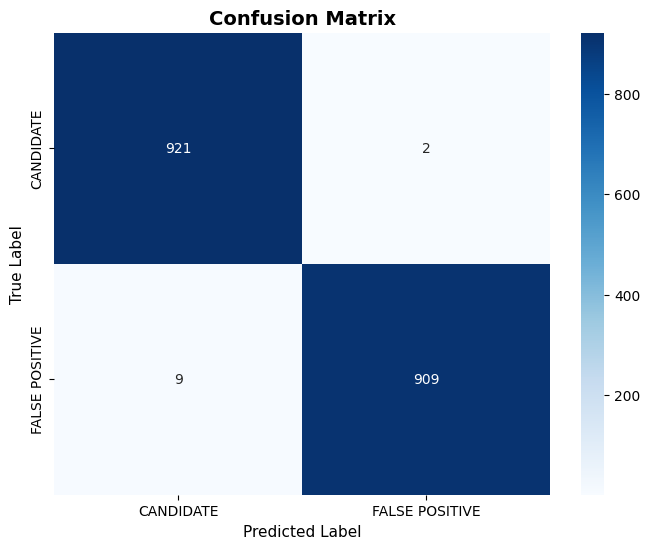

In [26]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['CANDIDATE', 'FALSE POSITIVE'],
            yticklabels=['CANDIDATE', 'FALSE POSITIVE'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.show()

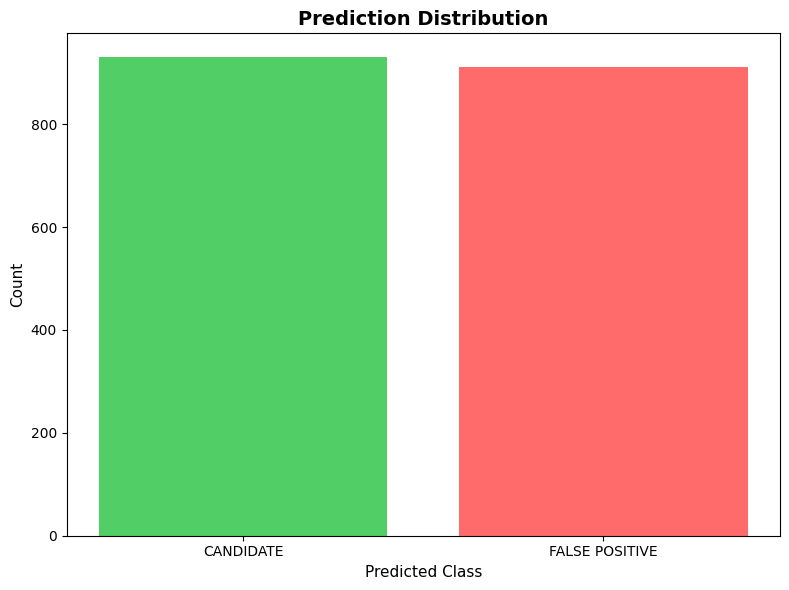

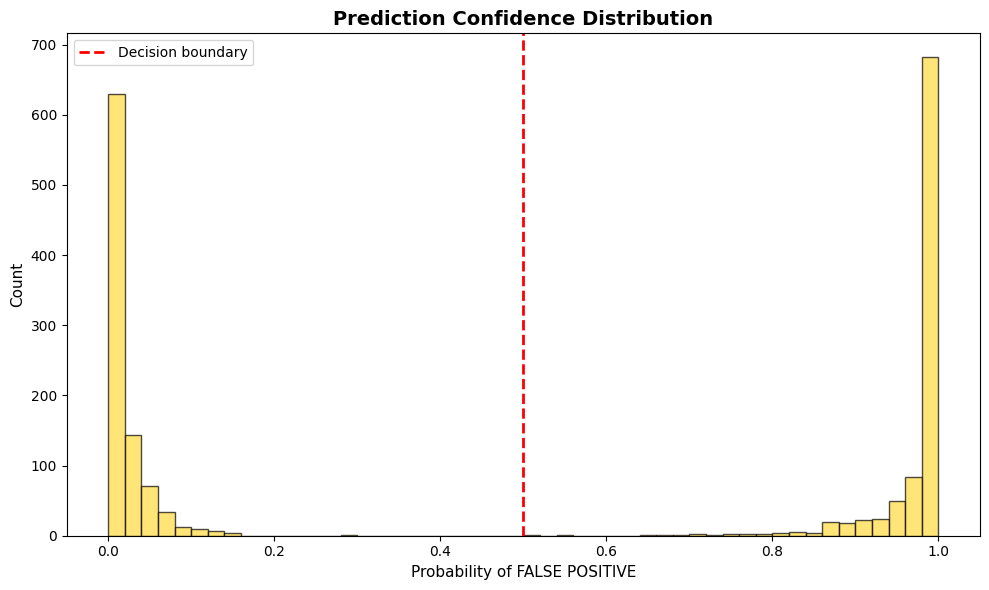